In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# nicer for demo
pd.options.display.max_rows = 3

Resources
* [Cookbook](https://github.com/jvns/pandas-cookbook) by Jake Vanderplas
* [Cheat Sheet](https://github.com/brandon-rhodes/pycon-pandas-tutorial/blob/master/cheat-sheet.txt) by Brandon Rhodes

---

# 1 - Reading Data

There are three Pandas data structures: **DataFrame**, **Series** (column), **Index** (column, row labels)

In contrast to **Numpy**, Pandas supports 2-D heterogenous data. Numpy supports arrays of arbitrary dimensions, but the data must be homogenous. 

In [4]:
# create a dataframe from a csv
flights = pd.read_csv("data/ny-flights.csv.gz",
                      parse_dates=["fl_date", "arr", "dep"])

`df.values` forces column values into a Numpy Array
    * CAREFUL: columns with mixed types are cast into objects (which are slower than native numpy types)

In [11]:
flights["dest"].values

array(['LAX', 'LAX', 'LAX', ..., 'IAH', 'IAH', 'ORD'], dtype=object)

## Indicies

indicies are names for columns and rows stored as native Pandas data type.

*Why bother with indices?*

Indices can make lookups and sorting tremendously faster. Brandon Rhodes shows an example that speeds up an operation by 400x. 

In [12]:
# column labels
flights.columns

Index(['fl_date', 'unique_carrier', 'airline_id', 'tail_num', 'fl_num',
       'origin', 'dest', 'dep_time', 'dep_delay', 'arr_time', 'arr_delay',
       'cancelled', 'arr', 'dep'],
      dtype='object')

In [18]:
# row labels
flights.index

RangeIndex(start=0, stop=20817, step=1)

## Search by Indicies: df.loc

`df.loc`: allows you to use the column, row indicies (labels)
    `df.loc[row_labels, column_labels]`

In [26]:
flights.loc[[25, 303], ["fl_date", "origin"]]

,fl_date,origin
25,2014-01-01,LGA
303,2014-01-01,JFK


* **careful**: this is different from the *ith row*. For that use `iloc`

In [6]:
flights.iloc[1]

fl_date    2014-01-01 00:00:00
                  ...         
dep        2014-01-01 11:57:00
Name: 1, Length: 14, dtype: object

---

# 2 - Filtering Data

## Boolean Indexing

NumPy and pandas use **|** for elementwise or, and **&** for elementwise and between two boolean arrays

In [61]:
# flights on 2014-01-01 leaving from JFK
flights[(flights["fl_date"] == "2014-01-01") & (flights["origin"] == "JFK")]

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,2014-01-01,AA,19805,N338AA,1,JFK,LAX,914.0,14.0,1238.0,13.0,0.0,2014-01-01 12:38:00,2014-01-01 09:14:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2014-01-01,VX,21171,N840VA,415,JFK,LAX,2015.0,15.0,2338.0,13.0,0.0,2014-01-01 23:38:00,2014-01-01 20:15:00


## df.isin

In [63]:
flights["origin"].isin(["JFK", "LGA"])

0         True
         ...  
20816    False
Name: origin, Length: 20817, dtype: bool

## Str Methods

Str is an attribute on a series with useful methods:
* series.str.startswith("Ham")
* series.str.contains("Hamlet")
* series.str.extract(regex pattern)
* series.str.len()

## Dropping a Column

`df.drop("column_name", axis=1)` returns a new dataframe without the column/s

In [44]:
flights.drop(["fl_date", "unique_carrier", "airline_id"], axis=1)
# use axis=0 to drop rows

,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,N338AA,1,JFK,LAX,914.0,14.0,1238.0,13.0,0.0,2014-01-01 12:38:00,2014-01-01 09:14:00
...,...,...,...,...,...,...,...,...,...,...,...
20816,N609MQ,3699,BUF,ORD,1208.0,-12.0,1251.0,-19.0,0.0,2014-01-31 12:51:00,2014-01-31 12:08:00


## Drop Rows in another DataFrame

In [5]:
bad_flights = flights[flights["cancelled"] == 0]

# use index.difference method
flights.drop(bad_flights.index, axis=0)

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
29,2014-01-01,AA,19805,N3EAAA,359,LGA,ORD,NaN,NaN,NaN,NaN,1.0,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20744,2014-01-31,MQ,20398,N502MQ,3531,LGA,RDU,NaN,NaN,NaN,NaN,1.0,NaT,NaT


---

# 3 - Combining Data

**Tip: use row indices! **

If you have two dataframe, Pandas will rely on row labels (indicies) to automatically join dataframes!

## Set Index

`df.set_index("DATE")` or you can directly read a column in as an index:

In [45]:
gdp = pd.read_csv('data/gdp.csv', index_col='DATE')

In [54]:
# remove index
gdp = gdp.reset_index()

## Handling Missing Data

### Drop

In [46]:
# returns a new object with na values dropped
gdp.dropna()

,GDP
DATE,
1947-01-01,243.1
...,...
2014-01-01,17025.2


### Fill

`ffill`: fills missing values with the previous available value

In [48]:
gdp.fillna(method='ffill')

,GDP
DATE,
1947-01-01,243.1
...,...
2014-01-01,17025.2


## Merging Datasets 

There are two ways

1. `pd.concat`: Tom recommends this for joining on **Indicies**
2. `pd.merge`: Tom recommends this for merging on **Columns**

In [55]:
pd.merge(gdp, flights, left_on="DATE", right_on="dep", how="outer")

,DATE,GDP,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,1947-01-01,243.1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21085,NaN,NaN,2014-01-31,UA,19977.0,N37293,1456.0,LGA,IAH,719.0,-6.0,1006.0,-20.0,0.0,2014-01-31 10:06:00,2014-01-31 07:19:00


# 4 - Sorting and Grouping Data

## Sorting

In [69]:
flights.sort_values(by=["origin", "dep_delay"])

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
10762,2014-01-16,EV,20366,N12563,3805,ALB,EWR,639.0,-16.0,810.0,10.0,0.0,2014-01-16 08:10:00,2014-01-16 06:39:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20702,2014-01-31,MQ,20398,N672MQ,3075,SYR,ORD,NaN,NaN,NaN,NaN,1.0,NaT,NaT


### Sorting Index

this can make lookups much faster

In [74]:
gdp.sort_index()

,DATE,GDP
0,1947-01-01,243.1
...,...,...
268,2014-01-01,17025.2


## Grouping

Pandas can perform `groupby` similar to SQL. 

CAREFUL: applying groupby returns a **groupby object**, not a dataframe!

You apply aggregator functions on these groups:
* `.sum(), .size() .mean() .min() .max()`

In [68]:
flights[["dep_delay", "origin"]].groupby("origin").mean()

,dep_delay
origin,
ALB,20.848429
...,...
SYR,28.597826


You can apply multiple aggregators

---

# 5 - Manipulating Data

### Series.apply(function)

In [77]:
gdp["GDP"].apply(lambda x: 2*x)

0        486.2
        ...   
268    34050.4
Name: GDP, Length: 269, dtype: float64

### Apply a function to the index

In [78]:
gdp.index.map(lambda x: x - 1)

Int64Index([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
            ...
            258, 259, 260, 261, 262, 263, 264, 265, 266, 267],
           dtype='int64', length=269)

### Parallelize Apply Function for PySpark
see https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html

In [ ]:
@pandas_udf(df.schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def subtract_mean(pdf):
    return pdf.assign(v=pdf.v - pdf.v.mean())

df.groupby('id').apply(subtract_mean)

## Encoding Categorical Data

### pd.factorize(series) to integer encode
operates like sk-learn `preprocessing.LabelEncoder()`

In [9]:
pd.factorize(flights["origin"])

(array([0, 0, 0, ..., 1, 1, 6]),
 Index(['JFK', 'LGA', 'SYR', 'ROC', 'HPN', 'SWF', 'BUF', 'ALB', 'ELM', 'ART',
        'ISP'],
       dtype='object'))

### pd.get_dummies(df) to create one-hot encoded columns

In [11]:
pd.get_dummies(flights[["origin", "dest"]])

,origin_ALB,origin_ART,origin_BUF,origin_ELM,origin_HPN,origin_ISP,origin_JFK,origin_LGA,origin_ROC,origin_SWF,...,dest_SJC,dest_SJU,dest_SLC,dest_SMF,dest_SRQ,dest_STL,dest_STT,dest_SYR,dest_TPA,dest_XNA
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20816,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---

# 6 - Tips

### Plotting

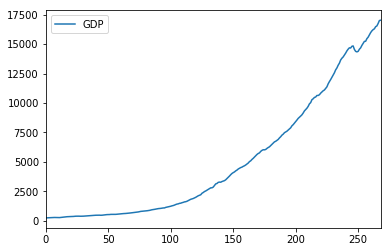

In [83]:
gdp.plot()

### Paste Dataframe into Excel
`to_clipboard()`

In [80]:
gdp.to_clipboard()

### Streaming with Iterators!

[Dask](https://dask.pydata.org/en/latest/): is an option to consider for distributing Pandas-like operations. It lazily defines a directed acyclic graph for computations. The API is very similar to that of Pandas.